In [1]:
import pickle

from gym.wrappers import FlattenObservation, RecordVideo, RescaleAction, TimeLimit
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import unwrap_wrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from environment import ARESEA
from utils import FilterAction, RecordData

In [2]:
with open("model_misalignments.pkl", "rb") as f:
    misalignments = pickle.load(f)
with open("model_incoming_parameters.pkl", "rb") as f:
    incoming_parameters = pickle.load(f)

def make_env():
    env = ARESEA(misalignments, incoming_parameters)
    env = FilterAction(env, [2,4], replace=0)
    env = TimeLimit(env, max_episode_steps=50)
    env = RecordData(env)
    env = FlattenObservation(env)
    env = RescaleAction(env, -1, 1)
    env = Monitor(env, info_keywords=("time_reward",))
    return env

env = DummyVecEnv([make_env])
env = VecNormalize.load("model_env.pkl", env)
env.training = False

model = PPO.load("model")

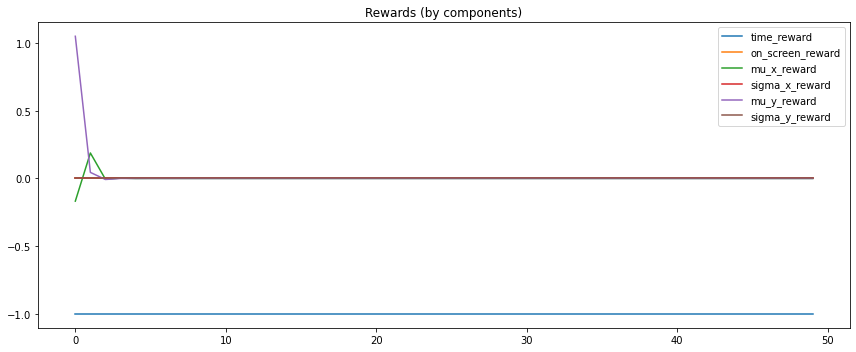

In [3]:
observation = env.reset()
done = False
while not done:
    action, _ = model.predict(observation, deterministic=True)
    observation, reward, done, info = env.step(action)

infos = unwrap_wrapper(env.envs[0], RecordData).previous_infos

time_reward = [info["time_reward"] for info in infos]
on_screen_reward = [info["on_screen_reward"] for info in infos]
mu_x_reward = [info["mu_x_reward"] for info in infos]
sigma_x_reward = [info["sigma_x_reward"] for info in infos]
mu_y_reward = [info["mu_y_reward"] for info in infos]
sigma_y_reward = [info["sigma_y_reward"] for info in infos]

plt.figure(figsize=(12,5))
plt.title("Rewards (by components)")
plt.plot(time_reward, label="time_reward")
plt.plot(on_screen_reward, label="on_screen_reward")
plt.plot(mu_x_reward, label="mu_x_reward")
plt.plot(sigma_x_reward, label="sigma_x_reward")
plt.plot(mu_y_reward, label="mu_y_reward")
plt.plot(sigma_y_reward, label="sigma_y_reward")
plt.legend()
plt.tight_layout()
plt.show()

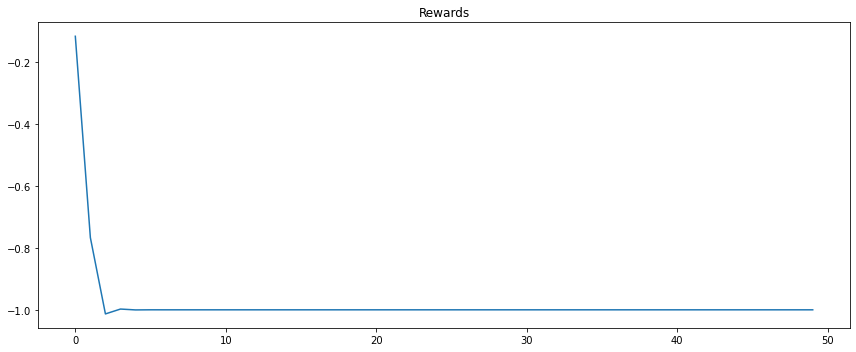

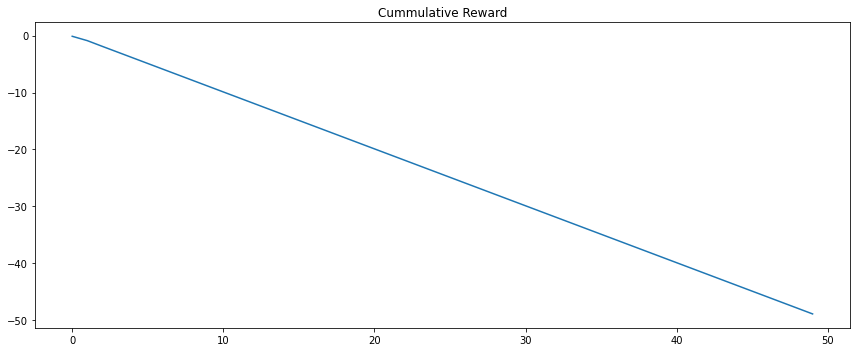

In [4]:
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.plot(unwrap_wrapper(env.envs[0], RecordData).previous_rewards)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.title("Cummulative Reward")
plt.plot(np.cumsum(unwrap_wrapper(env.envs[0], RecordData).previous_rewards))
plt.tight_layout()
plt.show()

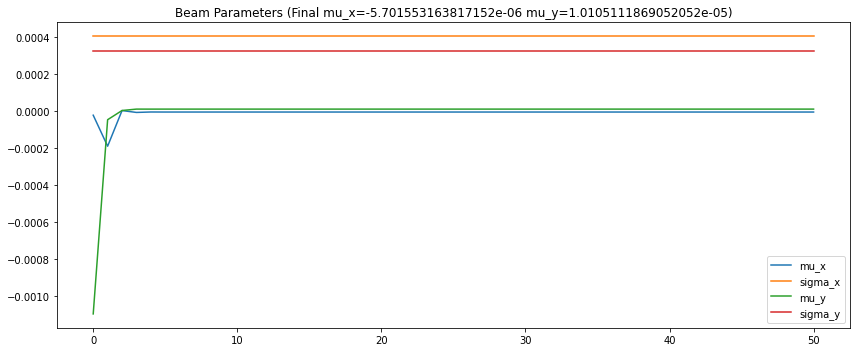

In [5]:
observations = unwrap_wrapper(env.envs[0], RecordData).previous_observations

mu_x = [observation["beam"][0] for observation in observations]
sigma_x = [observation["beam"][1] for observation in observations]
mu_y = [observation["beam"][2] for observation in observations]
sigma_y = [observation["beam"][3] for observation in observations]

plt.figure(figsize=(12,5))
plt.title(f"Beam Parameters (Final mu_x={mu_x[-1]} mu_y={mu_y[-1]})")
plt.plot(mu_x, label="mu_x")
plt.plot(sigma_x, label="sigma_x")
plt.plot(mu_y, label="mu_y")
plt.plot(sigma_y, label="sigma_y")
plt.legend()
plt.tight_layout()
plt.show()

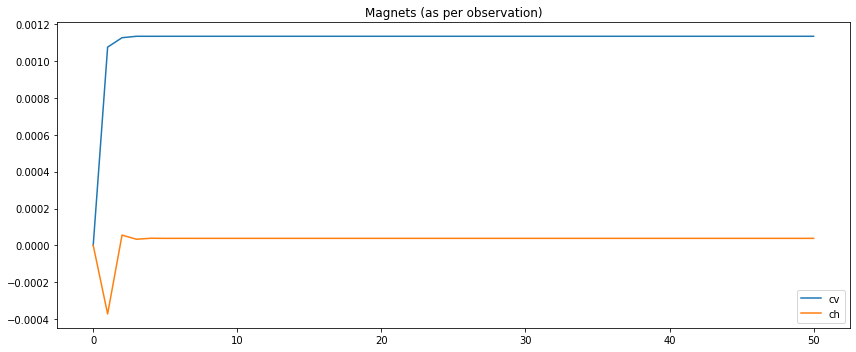

In [6]:
observations = unwrap_wrapper(env.envs[0], RecordData).previous_observations

cv = [observation["magnets"][2] for observation in observations]
ch = [observation["magnets"][4] for observation in observations]

plt.figure(figsize=(12,5))
plt.title("Magnets (as per observation)")
plt.plot(cv, label="cv")
plt.plot(ch, label="ch")
plt.legend()
plt.tight_layout()
plt.show()

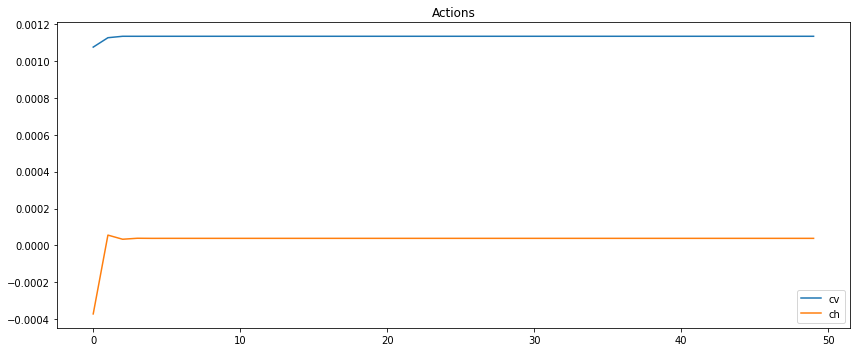

In [7]:
actions = unwrap_wrapper(env.envs[0], RecordData).previous_actions

cv = [action[0] for action in actions]
ch = [action[1] for action in actions]

plt.figure(figsize=(12,5))
plt.title("Actions")
plt.plot(cv, label="cv")
plt.plot(ch, label="ch")
plt.legend()
plt.tight_layout()
plt.show()